In [1]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

## Standard Statsmodels import
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## fixing random for lesson generation
np.random.seed(321)

## load data
df = pd.read_csv('Data/tmdb_results_combined.csv.gz')
df.head()

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,Two rural teens sing and dance their way throu...,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,Earth is in a state of constant war and two co...,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,"After falling prey to underworld, four friends...",...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,4.000,1.0,NaN
4,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.112,2009.0,PG


## Preprocessing
### Feature Engineering


 - lets convert 'belongs to collection' column to a boolean column

In [2]:
print(f"The number of unique values in 'belongs_to_collection' column is : ", df['belongs_to_collection'].nunique())
print("\nPreview of 'belongs_to_collection' column\n ", df['belongs_to_collection'].value_counts()[:5])

The number of unique values in 'belongs_to_collection' column is :  1870

Preview of 'belongs_to_collection' column
  {'id': 39199, 'name': 'Detective Conan Collection', 'poster_path': '/bV6EHK0Q65hHKSoVDeACbc960jQ.jpg', 'backdrop_path': '/wAaRpoB8Rkx8lTVzWR0vMCnotqN.jpg'}       17
{'id': 403643, 'name': 'Troublesome Night Collection', 'poster_path': '/bPTx3TP4UJTHQfcLx4qIub9LXmi.jpg', 'backdrop_path': '/n3a7zF5GuxM2X8oPF6pKXqYS6ER.jpg'}    15
{'id': 148065, 'name': 'Doraemon Collection', 'poster_path': '/4TLSP1KD1uAlp2q1rTrc6SFlktX.jpg', 'backdrop_path': '/rc6OFcSasL5YxBRPUQVwxmVF6h5.jpg'}             15
{'id': 23456, 'name': 'One Piece Collection', 'poster_path': '/zwXYjITRboH7nKGQmPXmCMRUHol.jpg', 'backdrop_path': '/3RqSKjokWlXyTBUt3tcR9CrOG57.jpg'}             13
{'id': 534673, 'name': 'Madea - Collection', 'poster_path': '/bO9NvwpSElW8lp33fGyy8VaS5s9.jpg', 'backdrop_path': '/qxLbjNPrMKTgYrMhIIDzj4zgYjf.jpg'}              11
Name: belongs_to_collection, dtype: int64


In [3]:
# From the above output we wouldn't want to OneHotEncode this column. 
# This would increase the number of our columns dramatically.

# If the row/movie is part of a collection we will assign the value True otherwise False
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()

False    49480
True      3539
Name: belongs_to_collection, dtype: int64

 - we need to extract just the genre from the genres column.

In [4]:
df['genres'].value_counts()

[{'id': 18, 'name': 'Drama'}]                                                                                                                                            8954
[]                                                                                                                                                                       5279
[{'id': 35, 'name': 'Comedy'}]                                                                                                                                           3659
[{'id': 27, 'name': 'Horror'}]                                                                                                                                           2520
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]                                                                                                              1651
                                                                                                                                  

In [5]:
# Lets grab an entry that requires engineering and develope a method to apply to the entire column
temp = df.loc[1, 'genres']
print("Before we apply engineering steps : ", temp)
temp = temp.replace("'",'"')
temp = json.loads(temp)

genres = []
for genre in temp:
    genres.append(genre['name'])
print("\n List of genres we need to encode: \n", genres)

Before we apply engineering steps :  [{'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'id': 10749, 'name': 'Romance'}]

 List of genres we need to encode: 
 ['Comedy', 'Music', 'Romance']


In [6]:
## Function to get just the genre names as a list 
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [7]:
## Use our function and exploding the new column
# df['genres_list'] = df['genres'].apply(get_genre_name)
# df_explode = df.explode('genres_list')
# df_explode


# In this block i'm getting an error. i'm not sure if its due to null values or not?

In [8]:
# ## save unique genres
# unique_genres = df_explode['genres_list'].dropna().unique()
# print(unique_genres)

# ## Manually One-Hot-Encode Genres
# for genre in unique_genres:
#     df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex =False)

# Drop original genre
# df  = df.drop(columns=['genres','genres_list'])

# df['genres'].head()

 - Converting year to sep features

In [9]:
df['release_date'].value_counts()

2009-01-01    265
2010-01-01    241
2008-01-01    231
2011-01-01    212
2012-01-01    189
             ... 
2004-03-09      1
2004-12-20      1
2001-11-27      1
2000-07-11      1
2021-01-08      1
Name: release_date, Length: 7161, dtype: int64

In [10]:
# From the above output we wouldn't want to OneHotEncode this column either. 
# This would increase the number of our columns dramatically.

# split release date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-', expand=True)
df[new_cols] = df[new_cols].astype(float) # why float?

# Drop original
df  = df.drop(columns=['release_date'])
df[['year','month','day']].head()

,year,month,day
0,NaN,NaN,NaN
1,2000.0,9.0,22.0
2,2000.0,11.0,15.0
3,2000.0,4.0,14.0
4,2000.0,9.0,29.0


 - Lets delete movies with 0 budget and 0 revenue.

    Make sure to only keep:

     - Status=Released.
     - Budget > 0
     - Revenue > 0

In [11]:
# Check status
df['status'].value_counts()

Released           53004
Post Production       13
In Production          1
Name: status, dtype: int64

In [12]:
# Save only Released status
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])

# filter out financials that don't have financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]

 - we need to extract just the company name from the production_company column

In [13]:
df['production_companies'].head()

4     [{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...
11    [{'id': 16934, 'logo_path': '/7HEUbdTlFQWf4SKi...
13    [{'id': 7, 'logo_path': '/vru2SssLX3FPhnKZGtYw...
16    [{'id': 1490, 'logo_path': None, 'name': 'Kint...
17    [{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...
Name: production_companies, dtype: object

In [14]:
# Lets pull out just one record as our test case
test = df.iloc[0]['production_companies']
test

# Creating column to track if a movie has a production company listed
df['has_prod_company'] = df['production_companies'] != '[]'

df[['production_companies','has_prod_company']]

,production_companies,has_prod_company
4,"[{'id': 539, 'logo_path': '/iPLtePguIzOPNtAWfT...",True
11,"[{'id': 16934, 'logo_path': '/7HEUbdTlFQWf4SKi...",True
13,"[{'id': 7, 'logo_path': '/vru2SssLX3FPhnKZGtYw...",True
16,"[{'id': 1490, 'logo_path': None, 'name': 'Kint...",True
17,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",True
...,...,...
52607,"[{'id': 86601, 'logo_path': None, 'name': 'Hum...",True
52613,"[{'id': 7036, 'logo_path': '/javbyY0ZCvlFJtly3...",True
52636,"[{'id': 44161, 'logo_path': '/tQ3Kj23ep0PN3HsH...",True
52851,"[{'id': 113206, 'logo_path': '/wnsT1H4ofxm3YOO...",True


In [15]:
# getting longest string to check for multiple companies
idxmax = df['production_companies'].apply(len).idxmax()

test = df.loc[idxmax, 'production_companies']
test

"[{'id': 8, 'logo_path': '/78ilmDNTpdCfsakrsLqmAUkFTrO.png', 'name': 'Fine Line Features', 'origin_country': ''}, {'id': 46, 'logo_path': '/3xFdKHLXPGHEbrAkmsepGE8974Y.png', 'name': 'WDR', 'origin_country': 'DE'}, {'id': 47, 'logo_path': '/i7Z9ot2o3N5Sa3HrF09kniFs2y8.png', 'name': 'Constantin Film', 'origin_country': 'DE'}, {'id': 76, 'logo_path': '/nebkQYtQKhZyHJfh5v0oGpNbPzu.png', 'name': 'Zentropa Entertainments', 'origin_country': 'DK'}, {'id': 94, 'logo_path': '/huC7HqorvUThGIrENrbcHmQVUA0.png', 'name': 'ARTE France Cinéma', 'origin_country': 'FR'}, {'id': 104, 'logo_path': '/9aotxauvc9685tq9pTcRJszuT06.png', 'name': 'Canal+', 'origin_country': 'FR'}, {'id': 119, 'logo_path': '/1di2gITGUZr730AMuMKiCrP90Vl.png', 'name': 'DR', 'origin_country': 'DK'}, {'id': 157, 'logo_path': None, 'name': 'SVT Drama', 'origin_country': ''}, {'id': 201, 'logo_path': '/6UIpEURdjnmcJPwgTDRzVRuwADr.png', 'name': 'ARTE', 'origin_country': 'FR'}, {'id': 321, 'logo_path': '/pfp6VWF3tYfOHHVRHpYe2iGcYrf.png

In [16]:
# using regular expressions to extrap just the name
exp= r"\'name\'\:.?\'(\w*.*?)\'"
re.findall(exp, test)
df['production_companies'].str.extractall(exp) # , expand=False ? doesnt work

0
      match                         
4     0             Block 2 Pictures
      1               Jet Tone Films
      2                   Orly Films
      3                Paradis Films
11    0       View Askew Productions
...                              ...
52613 1                   about Film
      2            Haegrimm Pictures
52636 0           Suresh Productions
52851 0      Celltrion Entertainment
52977 0            Signature Studios

[17886 rows x 1 columns]

In [17]:
# Define a method that returns the production company
def get_prod_company_names(x):
    if x=='[]':
        return ["MISSING"]
    
    exp= r"\'name\'\:.?\'(\w*.*?)\'"
    companies = re.findall(exp, x)
    return companies
#     return ','.join(companies)

In [18]:
# Test out method
# get_prod_company_names(test)

In [19]:
# Save new clean prod_comapny col and explode
df['prod_company'] = df['production_companies'].apply(get_prod_company_names)
prod_companies = df['prod_company'].explode()#.nunique()

# Display the companies that we found
# prod_companies.value_counts().head(49)

# Getting some error here ?

# Show a list of the top 50 companies
common_companies = sorted(prod_companies.value_counts().head(50).index)
common_companies

['20th Century Fox',
 'BBC Films',
 'Blumhouse Productions',
 'CJ Entertainment',
 'CNC',
 'Canal+',
 'Ciné+',
 'Columbia Pictures',
 'Dimension Films',
 'DreamWorks Pictures',
 'Dune Entertainment',
 'Epsilon Motion Pictures',
 'EuropaCorp',
 'Film4 Productions',
 'Focus Features',
 'Fox 2000 Pictures',
 'Fox Searchlight Pictures',
 'France 2 Cinéma',
 'France 3 Cinéma',
 'Ingenious Media',
 'Lakeshore Entertainment',
 'Legendary Pictures',
 'Lionsgate',
 'MISSING',
 'Metro-Goldwyn-Mayer',
 'Millennium Films',
 'Miramax',
 'New Line Cinema',
 'New Regency Pictures',
 'Original Film',
 'Paramount',
 'Regency Enterprises',
 'Relativity Media',
 'Revolution Studios',
 'Scott Rudin Productions',
 'Screen Gems',
 'Sony Pictures',
 'Spyglass Entertainment',
 'StudioCanal',
 'Summit Entertainment',
 'TF1 Films Production',
 'TSG Entertainment',
 'The Weinstein Company',
 'Touchstone Pictures',
 'Universal Pictures',
 'Village Roadshow Pictures',
 'Walt Disney Pictures',
 'Warner Bros. Pictur

In [20]:
# Output the number of companies that we are excluding
# rare_companies = prod_companies[prod_companies.isin(common_companies)==False].unique()
# len(rare_companies)

In [21]:
# manually ohe top 20 companies
for company in common_companies:
    df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)

# Drop unnecessary columns
drop_cols = ['prod_company','production_companies']

df = df.drop(columns=drop_cols)
df

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films
4,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,False,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo...",...,False,False,False,False,False,False,False,False,False,False
11,0.0,/knok3mNReKqPTplnnqz7E4dd7mD.jpg,False,120000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 27, 'name...",NaN,19085.0,en,Vulgar,Vulgar is about a man who is a children's clow...,...,False,False,False,False,False,False,False,False,False,False
13,0.0,/t7aJ7hqsMLEoqBJk7yAXxcAVvcz.jpg,True,45000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",NaN,7443.0,en,Chicken Run,Having been hopelessly repressed and facing ev...,...,False,False,False,False,False,False,False,False,False,False
16,0.0,/3vUkQpnwbsFEQlMh9EORpvKJfpo.jpg,False,8000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,318.0,en,The Million Dollar Hotel,The Million Dollar Hotel starts with a jump fr...,...,False,False,False,False,False,False,False,False,False,False
17,0.0,/24DZfupDlhXeTchmcOkoGRhP5Vg.jpg,True,125000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",NaN,955.0,en,Mission: Impossible II,With computer genius Luther Stickell at his si...,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52607,0.0,/siGTsYaWgZDRp20DX5A4fqaTA0E.jpg,True,1066375.0,"[{'id': 18, 'name': 'Drama'}]",NaN,603552.0,pa,Ardaas Karaan,"During times of conflict, three elderly men tr...",...,False,False,False,False,False,False,False,False,False,False
52613,0.0,/hn7oqr6RVqr3u6dcGoPRPi4jj1m.jpg,False,8120000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,567646.0,ko,극한직업,A drug squad attempts to take down a criminal ...,...,False,False,False,False,False,False,False,False,False,False
52636,0.0,/wZyqAWKxhoE6BBsBzgzplF8EwEn.jpg,False,3500000.0,"[{'id': 10751, 'name': 'Family'}, {'id': 35, '...",NaN,613853.0,te,వెంకీ మామా,When his sister and her husband die in a car a...,...,False,False,False,False,False,False,False,False,False,False
52851,0.0,/ynBh3v11Jkt1VzqThmkJLBDm2fK.jpg,False,12547000.0,"[{'id': 18, 'name': 'Drama'}]",NaN,571783.0,ko,자전차왕 엄복동,"During the Japanese colonial rule of Korea, wh...",...,False,False,False,False,False,False,False,False,False,False


### Delete unnecessary columns


In [22]:
## Other cleaning steps we could perform.
#     pull out genres? see above error.
drop_cols = ['backdrop_path','original_title','overview',
                 'poster_path','tagline','id','homepage',
                 'production_countries','video','spoken_languages',
            'original_language', 'genres', 'title']
df = df.drop(columns=drop_cols)

# Drop null values in revenue column
df.dropna(subset=['revenue'], inplace=True)

df.head()

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,year,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films
4,0.0,False,150000.0,22.355,12854953.0,99.0,8.112,2009.0,PG,2000.0,...,False,False,False,False,False,False,False,False,False,False
11,0.0,False,120000.0,4.261,14904.0,87.0,5.400,42.0,R,2002.0,...,False,False,False,False,False,False,False,False,False,False
13,0.0,True,45000000.0,71.989,224834564.0,84.0,6.700,4158.0,G,2000.0,...,False,False,False,False,False,False,False,False,False,False
16,0.0,False,8000000.0,13.298,105983.0,122.0,5.900,254.0,R,2000.0,...,False,False,False,False,False,False,False,False,False,False
17,0.0,True,125000000.0,36.364,546388105.0,123.0,6.100,5508.0,PG-13,2000.0,...,False,False,False,False,False,False,False,False,False,False


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4968 entries, 4 to 52977
Data columns (total 63 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   adult                               4968 non-null   float64
 1   belongs_to_collection               4968 non-null   bool   
 2   budget                              4968 non-null   float64
 3   popularity                          4968 non-null   float64
 4   revenue                             4968 non-null   float64
 5   runtime                             4968 non-null   float64
 6   vote_average                        4968 non-null   float64
 7   vote_count                          4968 non-null   float64
 8   certification                       3829 non-null   object 
 9   year                                4960 non-null   float64
 10  month                               4960 non-null   float64
 11  day                                 4960 n

# Perform train/test split


In [24]:
y = df['revenue']
X = df.drop(columns=['revenue'])
X_train,X_test, y_train, y_test = train_test_split(X, y, random_state=321)

# Preprocess our data before modeling

In [25]:
# Make a column selectors.
cat_selector = make_column_selector(dtype_include='object')
cat_cols = cat_selector(X_train)

num_selector = make_column_selector(dtype_include='number')
num_cols = num_selector(X_train)

In [26]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
bool_select(X_train)
# Missing genres. most probably due to the error above when cleaning genres column?

['belongs_to_collection',
 'has_prod_company',
 'ProdComp_20th Century Fox',
 'ProdComp_BBC Films',
 'ProdComp_Blumhouse Productions',
 'ProdComp_CJ Entertainment',
 'ProdComp_CNC',
 'ProdComp_Canal+',
 'ProdComp_Ciné+',
 'ProdComp_Columbia Pictures',
 'ProdComp_Dimension Films',
 'ProdComp_DreamWorks Pictures',
 'ProdComp_Dune Entertainment',
 'ProdComp_Epsilon Motion Pictures',
 'ProdComp_EuropaCorp',
 'ProdComp_Film4 Productions',
 'ProdComp_Focus Features',
 'ProdComp_Fox 2000 Pictures',
 'ProdComp_Fox Searchlight Pictures',
 'ProdComp_France 2 Cinéma',
 'ProdComp_France 3 Cinéma',
 'ProdComp_Ingenious Media',
 'ProdComp_Lakeshore Entertainment',
 'ProdComp_Legendary Pictures',
 'ProdComp_Lionsgate',
 'ProdComp_MISSING',
 'ProdComp_Metro-Goldwyn-Mayer',
 'ProdComp_Millennium Films',
 'ProdComp_Miramax',
 'ProdComp_New Line Cinema',
 'ProdComp_New Regency Pictures',
 'ProdComp_Original Film',
 'ProdComp_Paramount',
 'ProdComp_Regency Enterprises',
 'ProdComp_Relativity Media',
 'Pro

In [27]:
## convert manual ohe to int
already_ohe_cols = bool_select(X_train)
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

# Why are we doing this?

In [28]:
# Instantiate transformations

# Scaler
scaler = StandardScaler()

# Imputers
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')

# One Hot Encoding
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [29]:
# Make pipelines 
num_pipe = make_pipeline(num_imputer, scaler)
cat_pipe = make_pipeline(cat_imputer, ohe)

# Tuple the pipelines and column selectors
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

In [30]:
# Put everything in a column transformer
preprocessor = make_column_transformer(cat_tuple, num_tuple, remainder='passthrough', verbose_feature_names_out=False)

In [31]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000017C3A2DF130>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000017C3A2DF190>)],
                  verbose_feature_names_out=False)

# Preprocessing for statsmodels Linear Regression

In [32]:
# # Lets first extract the column names.
# final_features = []

# # Slice the pipeline to extract the One Hot Encoder
# ohe_step = preprocessor.named_transformers_['pipeline-1'][1]

# # Now, get One Hot Encoder feature names
# cat_features = ohe_step.get_feature_names_out(cat_cols)

# # Add the One Hot Enocoded column names to the list of feature names
# final_features.extend(cat_features)
# # Add the numeric column names to the list of feature names
# final_features.extend(num_cols)


# In the new sklearn we dont need to follow the steps above
final_features = preprocessor.get_feature_names_out()

In [33]:
# Create our dataframes with the column names that we just extracted
X_train_df = pd.DataFrame(preprocessor.transform(X_train), columns=final_features, index=X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), columns=final_features, index=X_test.index)

In [34]:
# Add constant column
X_train_df = sm.add_constant(X_train_df,has_constant='add', prepend=False)
X_test_df = sm.add_constant(X_test_df,has_constant='add', prepend=False)
display("Training data ", X_train_df.head(2), 'Testing data ', X_test_df.head(2))

# Year month and day are weird numbers, probably because of the float versus int above?

'Training data '

,certification_G,certification_MISSING,certification_NC-17,certification_PG,certification_PG-13,certification_R,certification_UR,adult,belongs_to_collection,budget,...,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films,const
39587,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.016385,-0.523719,-0.168061,...,-0.102848,-0.106774,-0.130082,-0.246848,-0.131145,-0.16349,-0.233726,-0.094529,-0.109316,1.0
45437,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.016385,-0.523719,-0.304183,...,-0.102848,-0.106774,-0.130082,-0.246848,-0.131145,-0.16349,-0.233726,-0.094529,-0.109316,1.0


'Testing data '

,certification_G,certification_MISSING,certification_NC-17,certification_PG,certification_PG-13,certification_R,certification_UR,adult,belongs_to_collection,budget,...,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films,const
27984,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.016385,1.909420,-0.71822,...,-0.102848,-0.106774,-0.130082,-0.246848,-0.131145,-0.16349,-0.233726,-0.094529,-0.109316,1.0
16179,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.016385,-0.523719,-0.62180,...,-0.102848,-0.106774,-0.130082,-0.246848,-0.131145,-0.16349,-0.233726,-0.094529,-0.109316,1.0


# Modeling

 ## - sklearn model


In [35]:
# Instantiate model
model = LinearRegression(fit_intercept=False)

# fit the model
model.fit(X_train_df, y_train)

# Define predictions
train_preds = model.predict(X_train_df)
test_preds = model.predict(X_test_df)

# find r-square
print('Training r2:', r2_score(y_train, train_preds))
print('Testing r2:', r2_score(y_test, test_preds))
# find mse
print('\nTraining MSE:', mean_squared_error(y_train, train_preds))
print('Testing MSE:', mean_squared_error(y_test, test_preds))

Training r2: 0.7695968858331198
Testing r2: 0.7743710788526068

Training MSE: 7727400900619123.0
Testing MSE: 9305234160595060.0


## - statsmodels


In [36]:
# instantiate model
model = sm.OLS(y_train, X_train_df, hasconst=True)

# We need to save the output of our .fit as a new variable
result = model.fit()

# Evaluate - get model performance metrics
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     185.2
Date:                Mon, 14 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:15:34   Log-Likelihood:                -73442.
No. Observations:                3726   AIC:                         1.470e+05
Df Residuals:                    3659   BIC:                         1.474e+05
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
certification_G                     3.075e+07   1.12e+07      2.748      0.006    8.81e+06    5.27e+07
certification_MISSING               1.395e+07   5.17e+06      2.699      0.007    3.82e+06    2.41e+07
certification_NC-17                  1.43e+07   2.62e+07      0.545      0.586   -3.71e+07    6.57e+07
certification_PG                    1.893e+07   5.98e+06      3.166      0.002    7.21e+06    3.07e+07
certification_PG-13                 9.609e+06   5.05e+06      1.901      0.057      -3e+05    1.95e+07
certification_R                    -1.048e+07   4.84e+06     -2.165      0.030      -2e+07   -9.91e+05
certification_UR                    8.555e+06   8.63e+06      0.991      0.322   -8.36e+06    2.55e+07
adult                               3.788e+05   1.46e+06      0.260      0.795   -2.48e+06    3.23e+06
belongs_to_collection               2.294e+07    1.6e+06     14.382      0.000    1.98e+07    2.61e+07
budget                              7.915e+07   2.28e+06     34.683      0.000    7.47e+07    8.36e+07
popularity                            7.3e+06   1.61e+06      4.545      0.000    4.15e+06    1.04e+07
runtime                             3.198e+06   1.62e+06      1.978      0.048    2.83e+04    6.37e+06
vote_average                       -1.227e+06   1.67e+06     -0.737      0.461   -4.49e+06    2.04e+06
vote_count                          8.746e+07    2.2e+06     39.765      0.000    8.31e+07    9.18e+07
year                                4.497e+06   1.59e+06      2.827      0.005    1.38e+06    7.62e+06
month                               1.185e+06   1.47e+06      0.805      0.421    -1.7e+06    4.07e+06
day                                -6.534e+05   1.47e+06     -0.445      0.657   -3.54e+06    2.23e+06
has_prod_company                   -2.694e+06   1.54e+06     -1.746      0.081   -5.72e+06    3.32e+05
ProdComp_20th Century Fox           1.441e+06   1.68e+06      0.856      0.392   -1.86e+06    4.74e+06
ProdComp_BBC Films                 -2.077e+05   1.47e+06     -0.141      0.888    -3.1e+06    2.68e+06
ProdComp_Blumhouse Productions     -1.732e+06    1.5e+06     -1.154      0.248   -4.67e+06    1.21e+06
ProdComp_CJ Entertainment           4.189e+05   1.46e+06      0.286      0.775   -2.45e+06    3.29e+06
ProdComp_CNC                        4.585e+05   1.62e+06      0.283      0.777   -2.72e+06    3.63e+06
ProdComp_Canal+                    -7.537e+05   2.07e+06     -0.365      0.715    -4.8e+06     3.3e+06
ProdComp_Ciné+                      4.863e+05   1.72e+06      0.282      0.778   -2.89e+06    3.87e+06
ProdComp_Columbia Pictures          -5.34e+06   1.69e+06     -3.159      0.002   -8.65e+06   -2.03e+06
ProdComp_Dimension Films           -9.381e+05    1.5e+06     -0.627      0.531   -3.87e+06      

In [37]:
# Getting the testing scores

# store test predictions 
test_preds = result.predict(X_test_df)

# We can then use any of the regression metrics from sklearn.metric's module
test_r2 = r2_score(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f'The testing r-square value is {test_r2.round(3)} and the testing mean squared error is {test_mse.round(3)}.')

The testing r-square value is 0.774 and the testing mean squared error is 9305876978049994.0.


# The Assumptions of Linear Regression

The 4 Assumptions of a Linear Regression are:
 - Linearity: The input features have a linear relationship with the target.
 
 - Independence of features (AKA Little-to-No Multicollinearity): The features are not strongly related to other features.
 
 - Normality: The model's residuals are approximately normally distributed.
 
 - Homoscedasticity: The model residuals have equal variance across all predictions.

### QQ-Plot for Checking for Normality

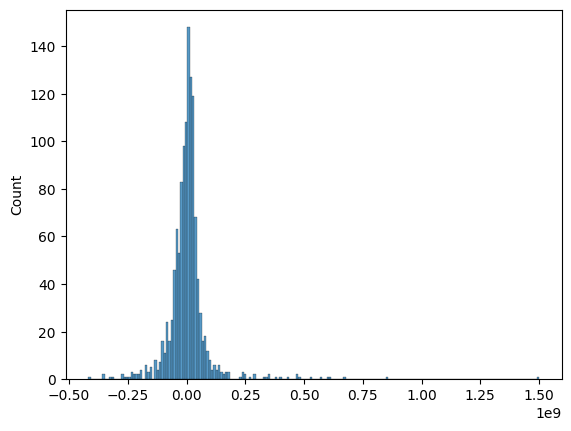

In [38]:
# first calculate residuals 
resid = y_test - test_preds

# Create a Q-QPlot
sns.histplot(resid);

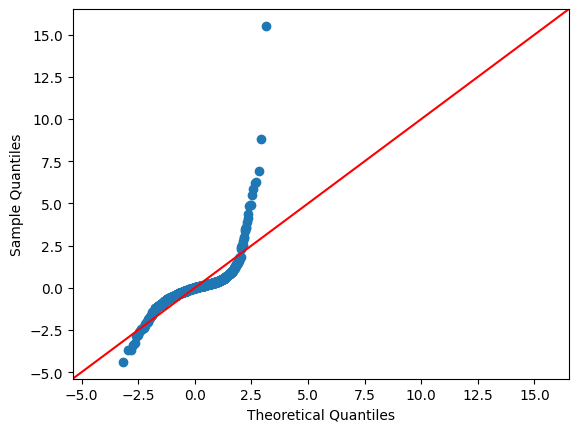

In [39]:
# then use sm's  qqplot
sm.graphics.qqplot(resid, line='45', fit=True);

### Residual Plot for Checking Homoscedasticity

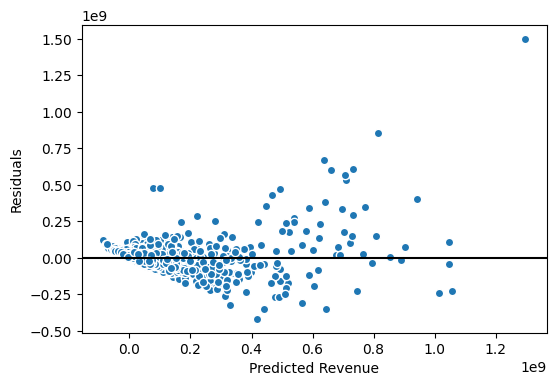

In [40]:
# Plot scatterplot with test_preds vs resids
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(test_preds, resid, ec='white')
ax.axhline(0, color='k')
ax.set(ylabel='Residuals',xlabel='Predicted Revenue');

In [41]:
# Lets put the above graphs into a function so we can reuse for later use
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression."""
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

### Checking our Coefficients


In [42]:
# extract the coefficients from model
# suppress scientific notation and add "," sep for 1,000's
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
result.params

certification_G                  30,747,224.31
certification_MISSING            13,952,736.55
certification_NC-17              14,299,513.89
certification_PG                 18,928,596.67
certification_PG-13               9,608,607.78
                                      ...     
ProdComp_Walt Disney Pictures    -1,529,320.34
ProdComp_Warner Bros. Pictures   -6,163,223.87
ProdComp_Wild Bunch              -1,472,486.75
ProdComp_Working Title Films     -2,958,230.59
const                            85,610,077.52
Length: 69, dtype: float64

# Improving Our Model
 ### Assumption of Linearity

Number of columns :  69


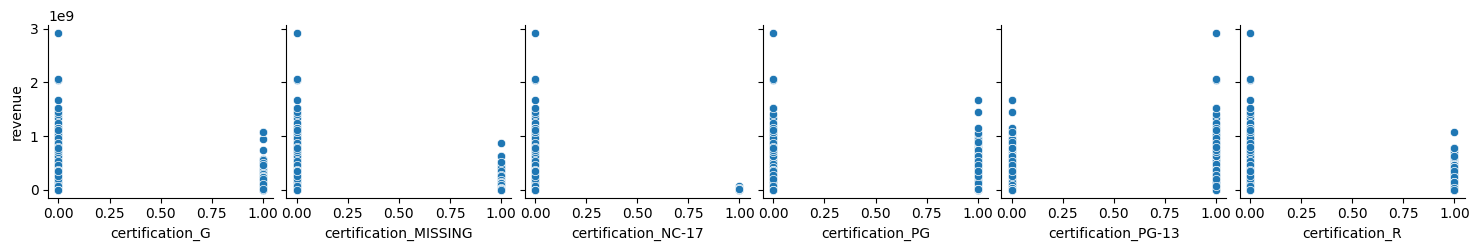

In [43]:
# concatenating training data into a dataframe that we will use for ploting
plot_df = pd.concat([X_train_df,y_train],axis=1)

# save plot_cols list to show (dropping genre from plot_df from pair_plot)
genre_cols = [c for c in df.columns if c.startswith('Genre')]
plot_cols = plot_df.drop(columns=['revenue',*genre_cols]).columns
print("Number of columns : ", len(plot_cols))

sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[:6]);

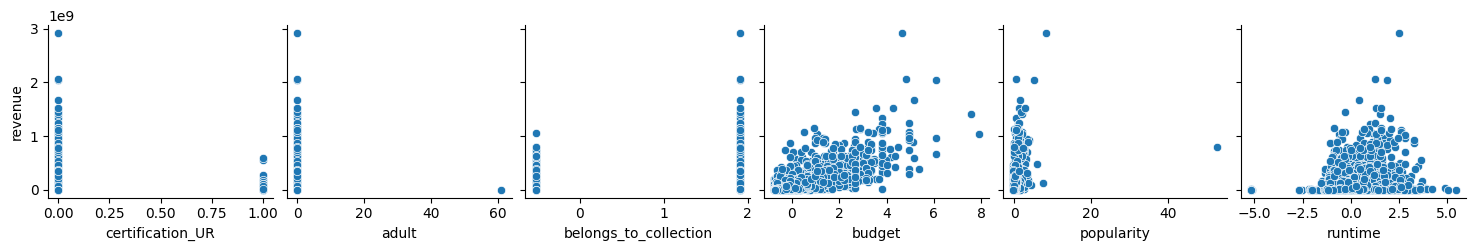

In [44]:
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[6:12]);

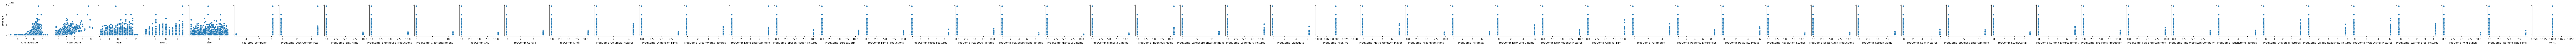

In [45]:
sns.pairplot(data=plot_df, y_vars='revenue',x_vars=plot_cols[12:]); #? there should only be 6 more plots

# Removing Outliers

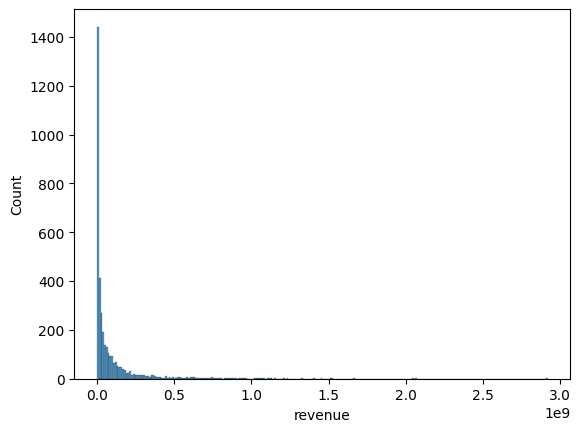

In [46]:
sns.histplot(plot_df['revenue']);

In [47]:
# Define a function that finds the outliers in a specific Series
def find_outliers(data, verbose=True):
    outliers = np.abs(stats.zscore(data))>3
    
    if verbose:
        print(f"- {outliers.sum()} outliers found in {data.name} using Z-Scores.")
    return outliers

In [48]:
# save a dictionary of the T/F outlier index for each feature in outleir_cols
outlier_cols = ['runtime','popularity','revenue']

outliers = {}
for col in outlier_cols:
    outliers_col = find_outliers(df[col])
    outliers[col] = outliers_col

- 64 outliers found in runtime using Z-Scores.
- 27 outliers found in popularity using Z-Scores.
- 127 outliers found in revenue using Z-Scores.


In [49]:
# Make new df_clean copy of df
df_clean = df.copy()

# loop through dictionary to remove outliers
for col, idx_outliers in outliers.items():
    df_clean = df_clean[~idx_outliers]
df_clean

C:\Users\default.DESKTOP-0LDO0LD\AppData\Local\Temp\ipykernel_528\4144025219.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_clean = df_clean[~idx_outliers]


,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,year,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films
4,0.00,False,"150,000.00",22.36,"12,854,953.00",99.00,8.11,"2,009.00",PG,"2,000.00",...,False,False,False,False,False,False,False,False,False,False
11,0.00,False,"120,000.00",4.26,"14,904.00",87.00,5.40,42.00,R,"2,002.00",...,False,False,False,False,False,False,False,False,False,False
13,0.00,True,"45,000,000.00",71.99,"224,834,564.00",84.00,6.70,"4,158.00",G,"2,000.00",...,False,False,False,False,False,False,False,False,False,False
16,0.00,False,"8,000,000.00",13.30,"105,983.00",122.00,5.90,254.00,R,"2,000.00",...,False,False,False,False,False,False,False,False,False,False
17,0.00,True,"125,000,000.00",36.36,"546,388,105.00",123.00,6.10,"5,508.00",PG-13,"2,000.00",...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52607,0.00,True,"1,066,375.00",1.07,"4,165,528.00",140.00,6.00,3.00,NaN,"2,019.00",...,False,False,False,False,False,False,False,False,False,False
52613,0.00,False,"8,120,000.00",17.75,"124,652,206.00",111.00,7.08,176.00,NaN,"2,019.00",...,False,False,False,False,False,False,False,False,False,False
52636,0.00,False,"3,500,000.00",4.00,"10,000,000.00",149.00,4.57,7.00,NaN,"2,019.00",...,False,False,False,False,False,False,False,False,False,False
52851,0.00,False,"12,547,000.00",3.33,"1,091,477.00",116.00,6.82,11.00,NaN,"2,019.00",...,False,False,False,False,False,False,False,False,False,False


In [50]:
## REPEAT PREPROCESSING CODE
## Make x and y variables
y = df_clean['revenue']
X = df_clean.drop(columns=['revenue'])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train

# make X_train_df
preprocessor.fit(X_train)
final_features = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)

X_test_df = pd.DataFrame( preprocessor.transform(X_test), 
                         columns=final_features, index=X_test.index)

## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_df, has_constant='add')
X_test_df = sm.add_constant(X_test_df, has_constant='add')
display(X_test_df.head(), X_train_df.head())

,const,certification_G,certification_MISSING,certification_NC-17,certification_PG,certification_PG-13,certification_R,certification_UR,adult,budget,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films
11812,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.02,0.24,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
49557,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.02,-0.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
34084,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.02,-0.79,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10217,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.02,-0.24,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
40682,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.02,-0.51,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,const,certification_G,certification_MISSING,certification_NC-17,certification_PG,certification_PG-13,certification_R,certification_UR,adult,budget,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films
41226,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.02,-0.68,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8381,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,-0.02,-0.43,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12331,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.02,-0.10,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
38207,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,-0.02,-0.79,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
39593,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.02,-0.26,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     188.9
Date:                Mon, 14 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:16:14   Log-Likelihood:                -68527.
No. Observations:                3575   AIC:                         1.372e+05
Df Residuals:                    3508   BIC:                         1.376e+05
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               6.406e+07   4.87e+06     13.156      0.000    5.45e+07    7.36e+07
certification_G                     2.213e+07   6.63e+06      3.341      0.001    9.15e+06    3.51e+07
certification_MISSING               9.765e+06    2.9e+06      3.370      0.001    4.08e+06    1.54e+07
certification_NC-17                 9.879e+06   1.38e+07      0.717      0.473   -1.71e+07    3.69e+07
certification_PG                    2.144e+07   3.52e+06      6.095      0.000    1.45e+07    2.83e+07
certification_PG-13                 5.364e+06   2.91e+06      1.843      0.065   -3.44e+05    1.11e+07
certification_R                    -9.055e+06   2.76e+06     -3.278      0.001   -1.45e+07   -3.64e+06
certification_UR                    4.536e+06   4.91e+06      0.924      0.356   -5.09e+06    1.42e+07
adult                               3.781e+04   8.64e+05      0.044      0.965   -1.66e+06    1.73e+06
budget                               4.68e+07   1.27e+06     36.907      0.000    4.43e+07    4.93e+07
popularity                          7.549e+06   1.22e+06      6.183      0.000    5.16e+06    9.94e+06
runtime                             3.289e+05   9.63e+05      0.342      0.733   -1.56e+06    2.22e+06
vote_average                        4.245e+05    9.9e+05      0.429      0.668   -1.52e+06    2.37e+06
vote_count                          4.861e+07    1.3e+06     37.339      0.000    4.61e+07    5.12e+07
year                               -4.612e+05   9.49e+05     -0.486      0.627   -2.32e+06     1.4e+06
month                                3.35e+05   8.75e+05      0.383      0.702   -1.38e+06    2.05e+06
day                                -4.549e+05   8.73e+05     -0.521      0.602   -2.17e+06    1.26e+06
belongs_to_collection               3.499e+07   2.35e+06     14.858      0.000    3.04e+07    3.96e+07
has_prod_company                    -6.87e+06   5.05e+06     -1.360      0.174   -1.68e+07    3.03e+06
ProdComp_20th Century Fox           1.918e+07   5.38e+06      3.568      0.000    8.64e+06    2.97e+07
ProdComp_BBC Films                 -1.429e+06   8.64e+06     -0.165      0.869   -1.84e+07    1.55e+07
ProdComp_Blumhouse Productions       2.06e+06    9.1e+06      0.226      0.821   -1.58e+07    1.99e+07
ProdComp_CJ Entertainment           8.712e+05   1.01e+07      0.087      0.931   -1.88e+07    2.06e+07
ProdComp_CNC                        3.904e+06   1.01e+07      0.388      0.698   -1.58e+07    2.36e+07
ProdComp_Canal+                    -9.281e+06   6.24e+06     -1.487      0.137   -2.15e+07    2.95e+06
ProdComp_Ciné+                       1.11e+07   1.04e+07      1.071      0.284   -9.22e+06    3.14e+07
ProdComp_Columbia Pictures          2.343e+06   4.75e+06      0.493      0.622   -6.98e+06    1.

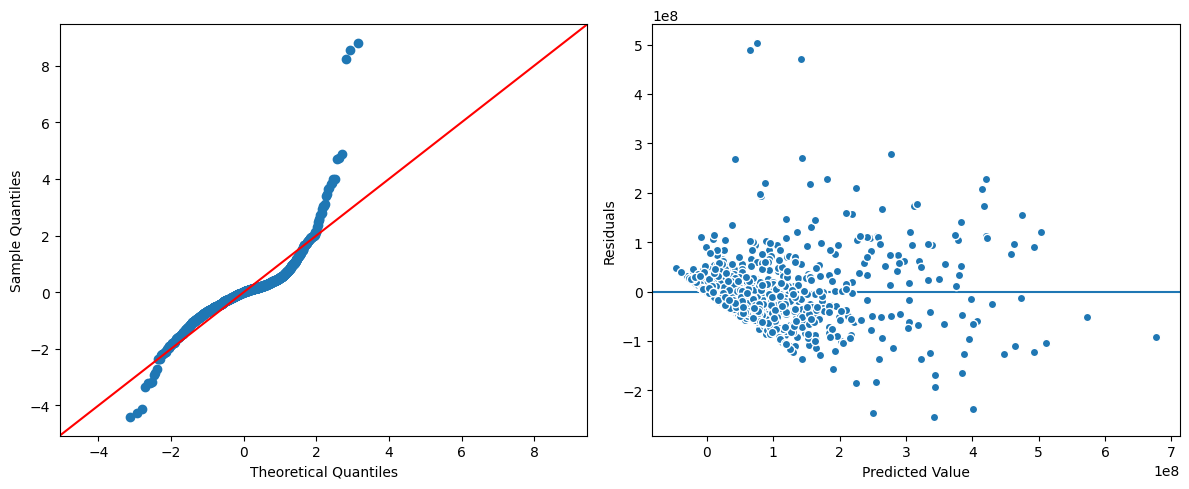

In [51]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result,X_test_df,y_test)

result.summary()

# Addressing Multicollinearity

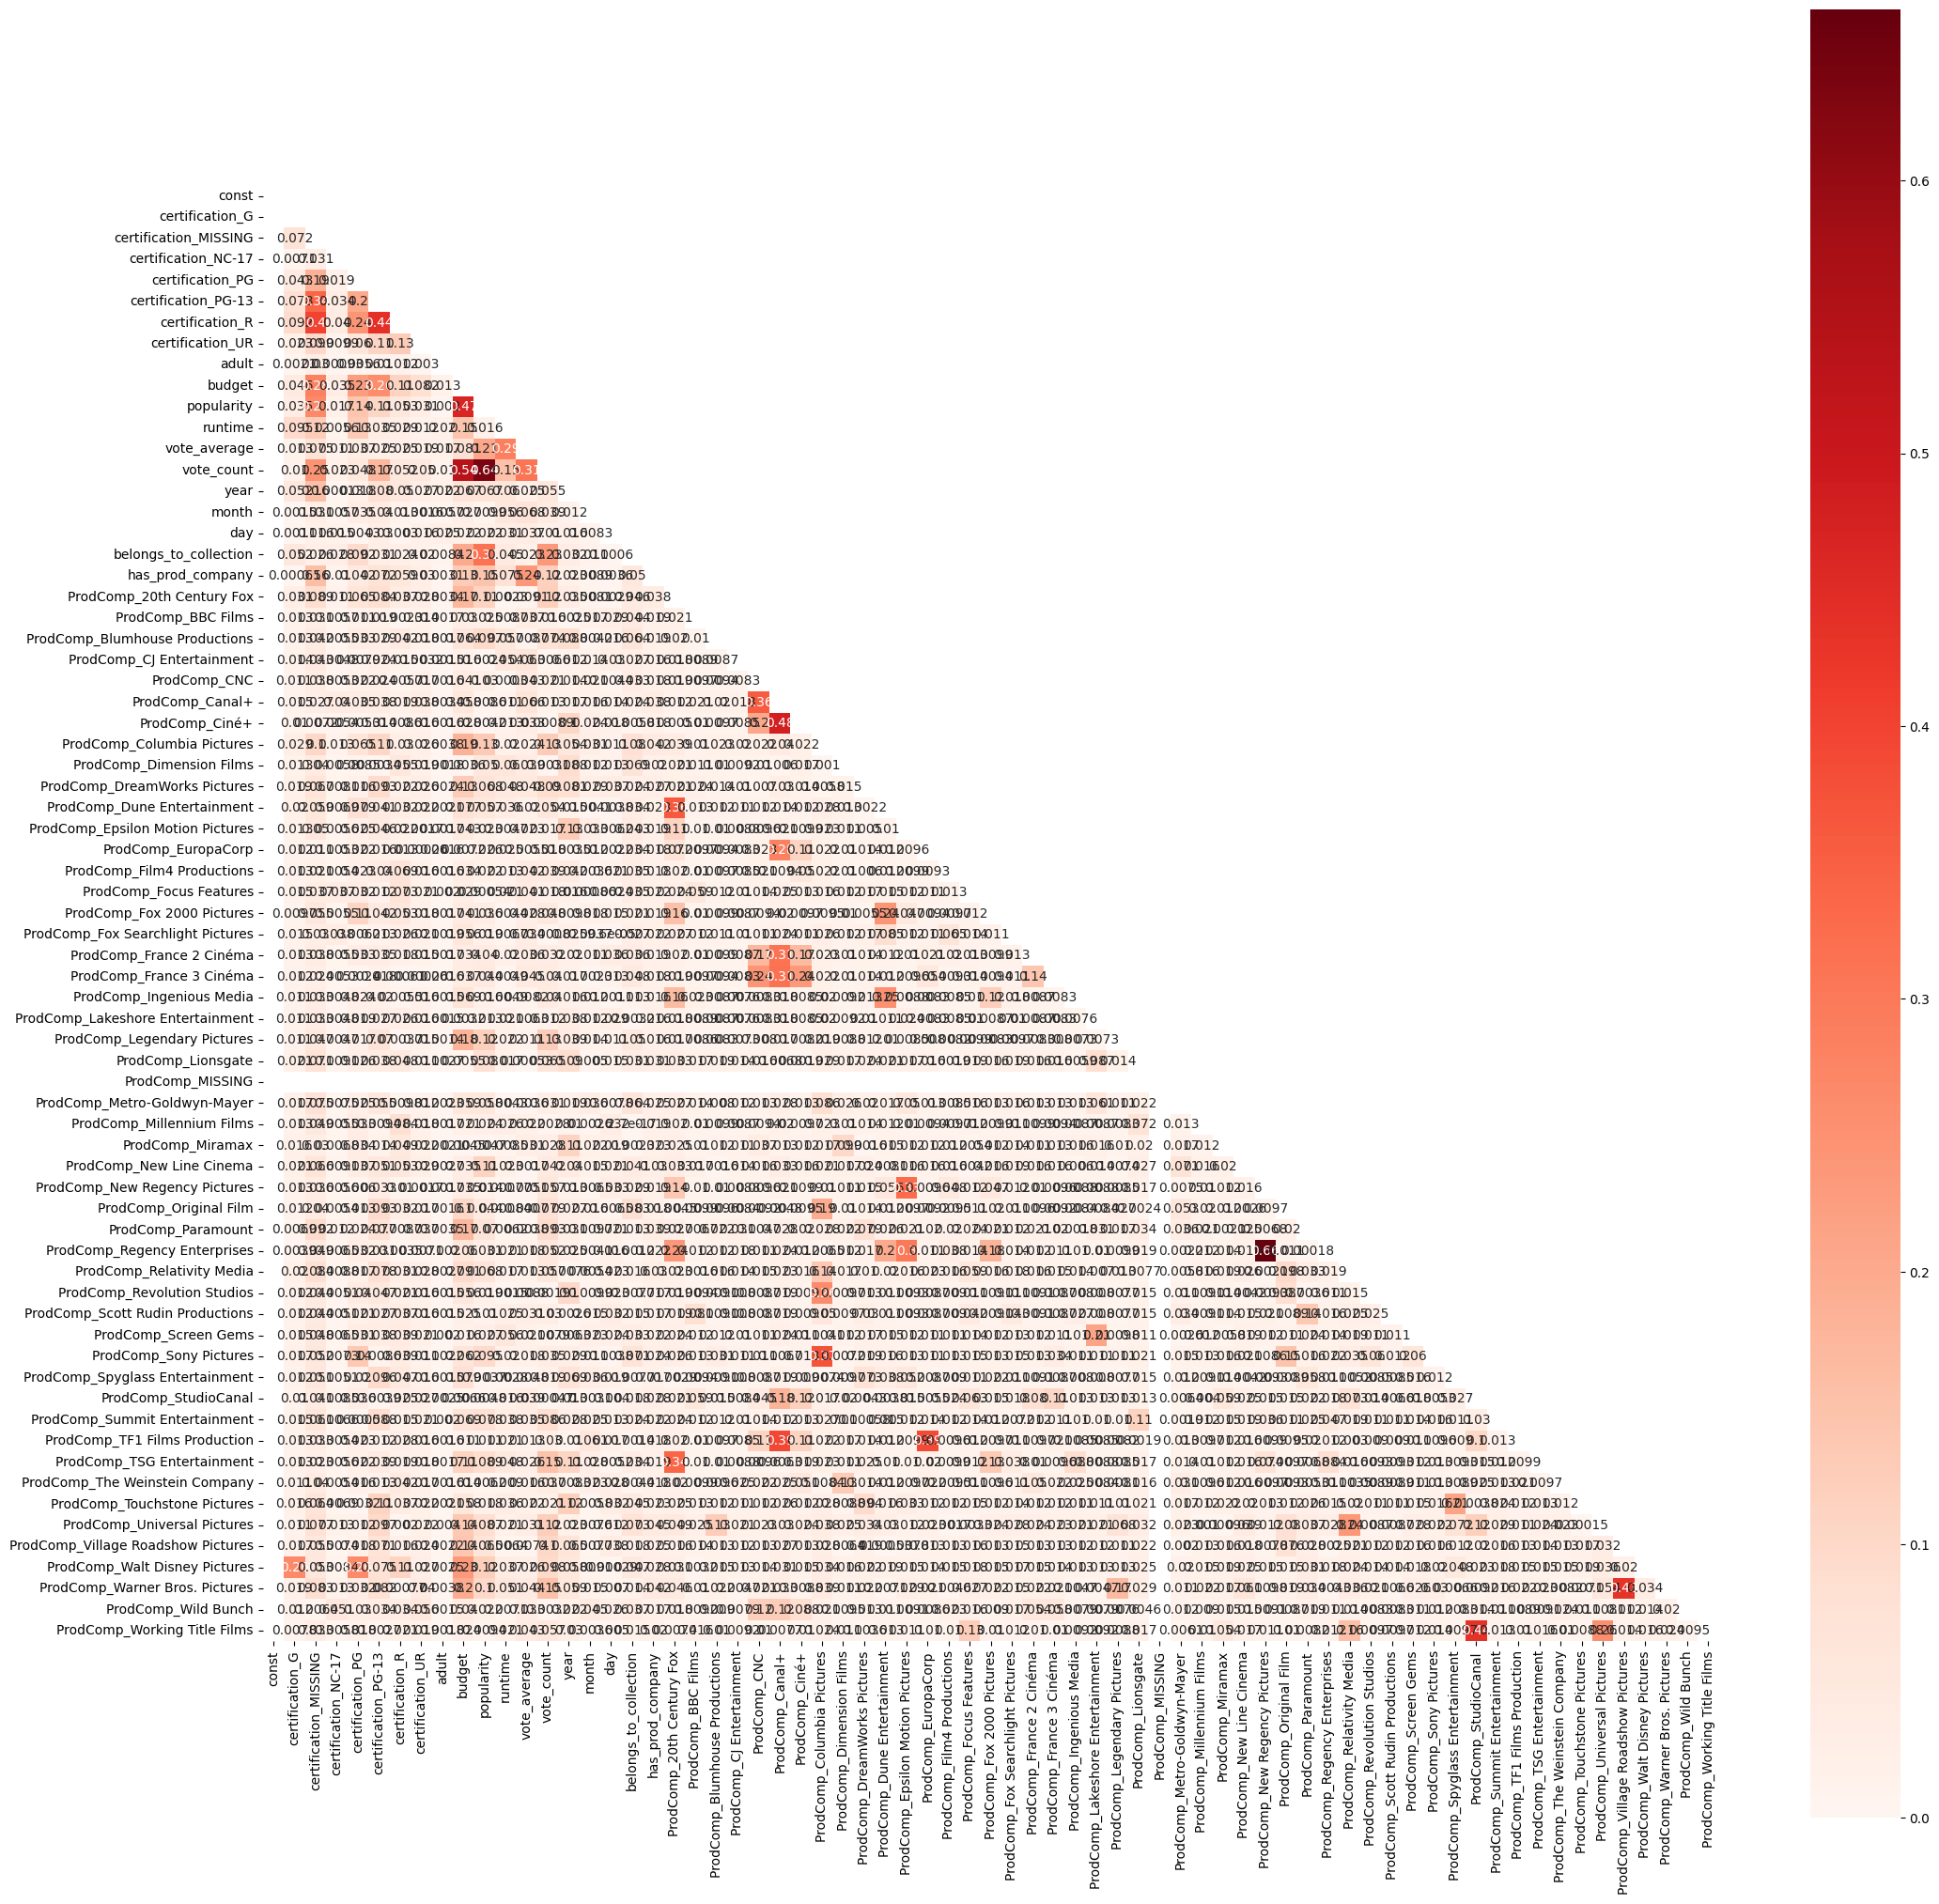

In [52]:
# Calculating the mask to hide the upper-right of the triangle
plt.figure(figsize=(25,25))
corr = X_train_df.corr().abs()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr,square=True, cmap='Reds', annot=True, mask=mask);
# how can we possibly see all the values?

Because there are no correlations greater or less then 8.0 and -8.0 we don't need to change anything. However, if two features were strongly correlated we would need to drop one of them before continuing with our final model.

Is this true?

# Variance Inflation Factor

In [53]:
# separate just x-data and subtract mean
features = X_train_df - X_train_df.mean()

# create a list of VIF scores for each feature in features.
vif_scores = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

# create a new dataframe to hold the VIF scores 
VIF = pd.Series(vif_scores, index=features.columns)

# Sort VIF for inspection
print("Sorted VIF WITH infinite values\n", VIF.sort_values())

# Getting a lot of infinite values, is this ok?

## remove infinite values from VIF and sort
VIF = VIF[VIF!=np.inf].sort_values()
print("\n\nSorted VIF WITHOUT infinite values\n", VIF)

C:\Users\default.DESKTOP-0LDO0LD\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\default.DESKTOP-0LDO0LD\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Sorted VIF WITH infinite values
 adult                       1.00
ProdComp_CJ Entertainment   1.02
day                         1.02
ProdComp_BBC Films          1.03
ProdComp_Millennium Films   1.03
                            ... 
certification_R              inf
certification_PG             inf
certification_G              inf
const                        NaN
ProdComp_MISSING             NaN
Length: 69, dtype: float64


Sorted VIF WITHOUT infinite values
 adult                          1.00
ProdComp_CJ Entertainment      1.02
day                            1.02
ProdComp_BBC Films             1.03
ProdComp_Millennium Films      1.03
                               ... 
ProdComp_Regency Enterprises   2.01
budget                         2.16
vote_count                     2.28
const                           NaN
ProdComp_MISSING                NaN
Length: 62, dtype: float64


In [54]:
## filter for VIF that are > 5
VIF[VIF>5]

high_vif = VIF[VIF>5].index
high_vif

# Nothing showing up? may be due to previous issues with genre.

Index([], dtype='object')

# Final Model

In [55]:
df_final = df_clean.drop(columns='certification')
df_final

# Why are we dropping the certification column?

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,year,month,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films
4,0.00,False,"150,000.00",22.36,"12,854,953.00",99.00,8.11,"2,009.00","2,000.00",9.00,...,False,False,False,False,False,False,False,False,False,False
11,0.00,False,"120,000.00",4.26,"14,904.00",87.00,5.40,42.00,"2,002.00",4.00,...,False,False,False,False,False,False,False,False,False,False
13,0.00,True,"45,000,000.00",71.99,"224,834,564.00",84.00,6.70,"4,158.00","2,000.00",6.00,...,False,False,False,False,False,False,False,False,False,False
16,0.00,False,"8,000,000.00",13.30,"105,983.00",122.00,5.90,254.00,"2,000.00",2.00,...,False,False,False,False,False,False,False,False,False,False
17,0.00,True,"125,000,000.00",36.36,"546,388,105.00",123.00,6.10,"5,508.00","2,000.00",5.00,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52607,0.00,True,"1,066,375.00",1.07,"4,165,528.00",140.00,6.00,3.00,"2,019.00",7.00,...,False,False,False,False,False,False,False,False,False,False
52613,0.00,False,"8,120,000.00",17.75,"124,652,206.00",111.00,7.08,176.00,"2,019.00",1.00,...,False,False,False,False,False,False,False,False,False,False
52636,0.00,False,"3,500,000.00",4.00,"10,000,000.00",149.00,4.57,7.00,"2,019.00",12.00,...,False,False,False,False,False,False,False,False,False,False
52851,0.00,False,"12,547,000.00",3.33,"1,091,477.00",116.00,6.82,11.00,"2,019.00",2.00,...,False,False,False,False,False,False,False,False,False,False


In [56]:
# Make x and y variables
y = df_final['revenue']
X = df_final.drop(columns=['revenue'])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=321)
X_train

# make X_train_df
preprocessor.fit(X_train)
final_features = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame( preprocessor.transform(X_train), columns=final_features, index=X_train.index)

X_test_df = pd.DataFrame( preprocessor.transform(X_test), columns=final_features, index=X_test.index)

## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_df, has_constant='add')
X_test_df = sm.add_constant(X_test_df, has_constant='add')
display(X_test_df.head(), X_train_df.head())

,const,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films
11812,1.00,-0.02,0.24,-0.39,-1.47,-1.26,-0.51,-0.38,-0.24,1.13,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
49557,1.00,-0.02,-0.75,-0.74,-0.67,1.75,-0.61,1.63,1.51,1.36,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
34084,1.00,-0.02,-0.79,-0.66,-1.96,0.22,-0.61,1.08,-1.70,0.78,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10217,1.00,-0.02,-0.24,0.03,-0.19,0.38,0.52,-0.56,-0.83,-0.39,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
40682,1.00,-0.02,-0.51,0.08,-0.67,0.90,0.70,1.27,-0.53,0.31,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,const,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Wild Bunch,ProdComp_Working Title Films
41226,1.00,-0.02,-0.68,-0.45,-0.99,-0.14,-0.59,1.27,-1.70,0.43,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8381,1.00,-0.02,-0.43,-0.32,0.67,1.10,-0.11,-0.75,-1.12,0.19,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12331,1.00,-0.02,-0.10,-0.55,-1.37,-0.63,-0.52,-0.38,-1.12,-0.97,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
38207,1.00,-0.02,-0.79,-0.79,1.95,0.98,-0.64,1.08,-0.83,-0.86,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
39593,1.00,-0.02,-0.26,-0.16,0.13,-0.50,0.14,1.27,0.63,1.48,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     199.7
Date:                Mon, 14 Nov 2022   Prob (F-statistic):               0.00
Time:                        19:16:39   Log-Likelihood:                -68584.
No. Observations:                3575   AIC:                         1.373e+05
Df Residuals:                    3514   BIC:                         1.377e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                               7.052e+07   5.01e+06     14.086      0.000    6.07e+07    8.03e+07
adult                               1.702e+05   8.77e+05      0.194      0.846   -1.55e+06    1.89e+06
budget                              4.891e+07   1.24e+06     39.527      0.000    4.65e+07    5.13e+07
popularity                          7.255e+06   1.23e+06      5.895      0.000    4.84e+06    9.67e+06
runtime                            -2.492e+05   9.48e+05     -0.263      0.793   -2.11e+06    1.61e+06
vote_average                        9.688e+05      1e+06      0.968      0.333   -9.92e+05    2.93e+06
vote_count                          4.676e+07   1.31e+06     35.804      0.000    4.42e+07    4.93e+07
year                                3.803e+05   9.52e+05      0.399      0.690   -1.49e+06    2.25e+06
month                               6.032e+05   8.88e+05      0.680      0.497   -1.14e+06    2.34e+06
day                                -5.338e+05   8.86e+05     -0.603      0.547   -2.27e+06     1.2e+06
belongs_to_collection               3.673e+07   2.37e+06     15.524      0.000    3.21e+07    4.14e+07
has_prod_company                   -1.006e+07    5.1e+06     -1.973      0.049      -2e+07   -6.31e+04
ProdComp_20th Century Fox           2.048e+07   5.44e+06      3.762      0.000     9.8e+06    3.12e+07
ProdComp_BBC Films                 -1.197e+06   8.77e+06     -0.137      0.891   -1.84e+07     1.6e+07
ProdComp_Blumhouse Productions      -2.03e+06   9.21e+06     -0.220      0.826   -2.01e+07     1.6e+07
ProdComp_CJ Entertainment            3.38e+06   1.02e+07      0.331      0.740   -1.66e+07    2.34e+07
ProdComp_CNC                        5.621e+06   1.02e+07      0.551      0.582   -1.44e+07    2.56e+07
ProdComp_Canal+                    -1.072e+07   6.32e+06     -1.696      0.090   -2.31e+07    1.67e+06
ProdComp_Ciné+                      1.231e+07   1.05e+07      1.172      0.241   -8.29e+06    3.29e+07
ProdComp_Columbia Pictures          1.851e+06   4.81e+06      0.385      0.701   -7.59e+06    1.13e+07
ProdComp_Dimension Films           -1.198e+07   8.68e+06     -1.380      0.168    -2.9e+07    5.04e+06
ProdComp_DreamWorks Pictures        1.258e+07   6.33e+06      1.986      0.047    1.58e+05     2.5e+07
ProdComp_Dune Entertainment         6.262e+06   8.21e+06      0.763      0.446   -9.84e+06    2.24e+07
ProdComp_Epsilon Motion Pictures   -1.447e+07   9.56e+06     -1.513      0.130   -3.32e+07    4.28e+06
ProdComp_EuropaCorp                -2.613e+07   1.04e+07     -2.521      0.012   -4.64e+07   -5.81e+06
ProdComp_Film4 Productions         -2.148e+07   9.16e+06     -2.347      0.019   -3.94e+07   -3.53e+06
ProdComp_Focus Features            -2.265e+06   7.68e+06     -0.295      0.768   -1.73e+07    1.

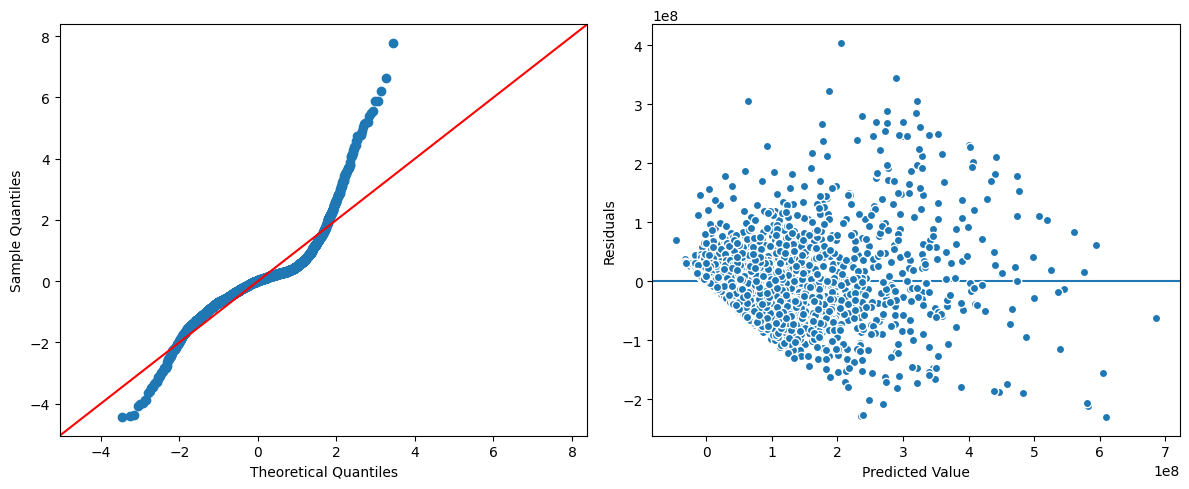

In [57]:
## instantiate an OLS model WITH the training data.
model = sm.OLS(y_train, X_train_df)

## Fit the model and view the summary
result = model.fit()

evaluate_ols(result,X_train_df,y_train)

result.summary()

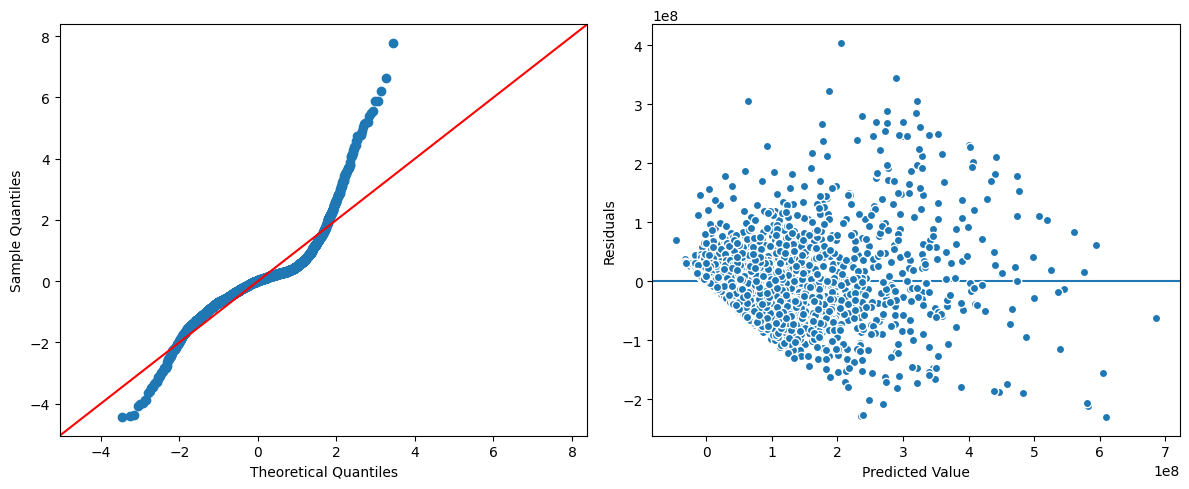

In [58]:
evaluate_ols(result,X_train_df,y_train)

plt.savefig('Visuals/final_model_graphs.png', pad_inches=1)

C:\Users\default.DESKTOP-0LDO0LD\AppData\Local\Temp\ipykernel_528\464196627.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


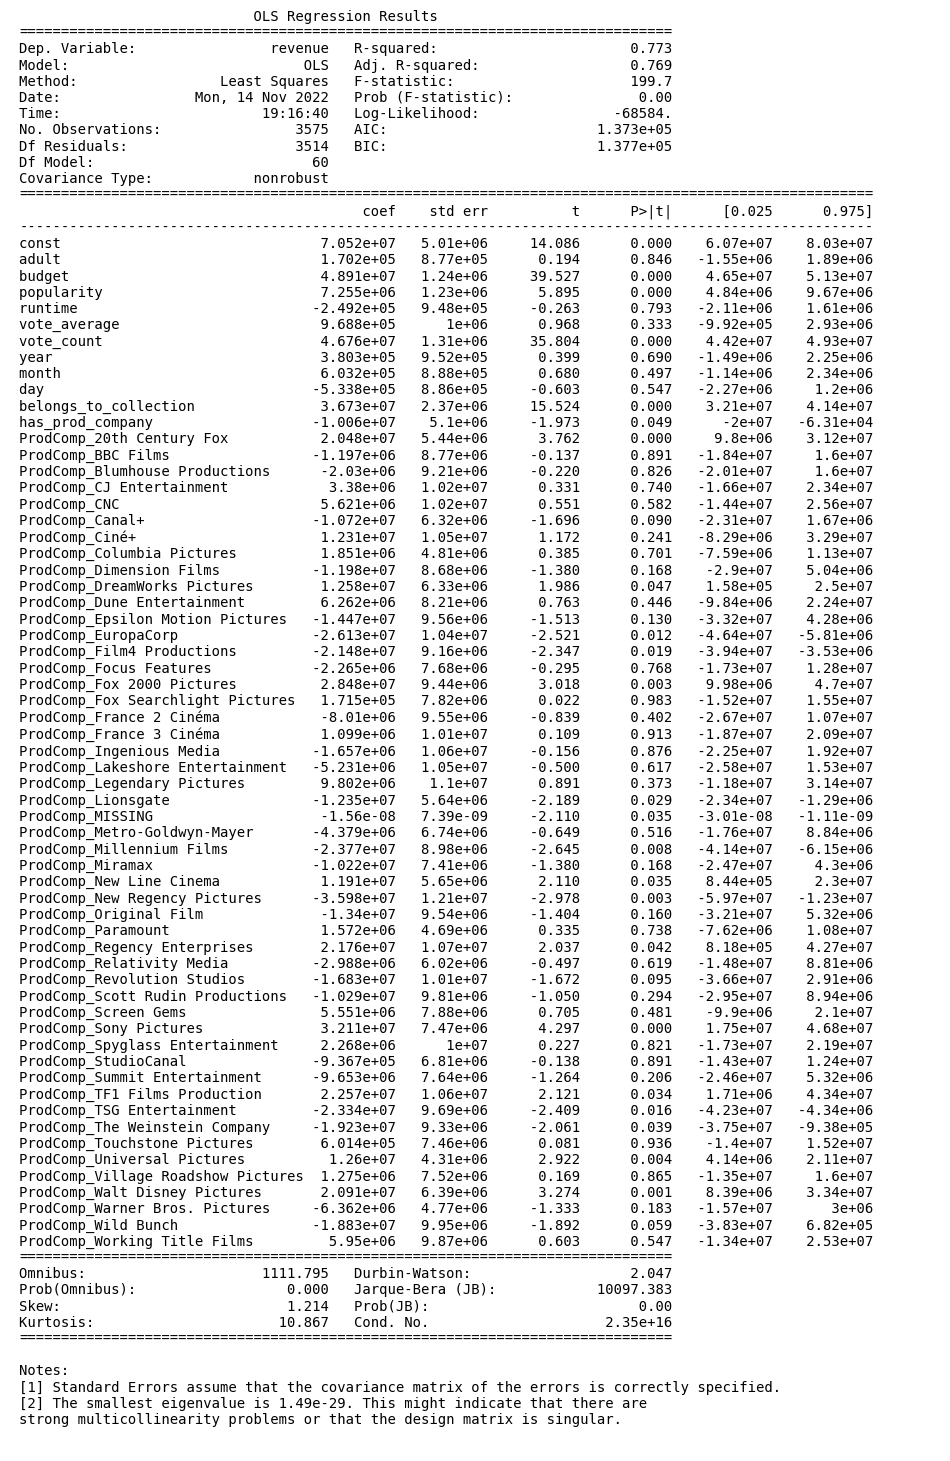

In [59]:
# save results
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(result.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('Visuals/final_model_results.png')

In [60]:
# Getting the testing scores

# store test predictions 
test_preds = result.predict(X_test_df)

test_r2 = r2_score(y_test, test_preds)
test_mse = mean_squared_error(y_test, test_preds)

print(f'For testing data:\nr-square : is {test_r2.round(3)} \nMean Squared Error(MSE) : {test_mse.round(3)}.')
#? This performed worse then the model with less cleaning

For testing data:
r-square : is 0.723 
Mean Squared Error(MSE) : 3343948347544315.5.


In [61]:
result.params

const                                 70,518,689.29
adult                                    170,249.96
budget                                48,914,169.57
popularity                             7,254,645.27
runtime                                 -249,166.43
                                          ...      
ProdComp_Village Roadshow Pictures     1,274,755.01
ProdComp_Walt Disney Pictures         20,909,486.42
ProdComp_Warner Bros. Pictures        -6,362,112.55
ProdComp_Wild Bunch                  -18,829,434.09
ProdComp_Working Title Films           5,950,236.25
Length: 62, dtype: float64

In [62]:
# Is there anything else that i've missed?